## Header

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import statsmodels.formula.api as smf
from sklearn.model_selection import ShuffleSplit
import sklearn.metrics as metrics
#from collections import Counter 
import numpy as np

## Exploration and Cleaning

In [2]:
# import training data
df = pd.read_csv("train.csv")
#print("Head:\n", df.head(10))
#print("Table size :", df.shape)
#print("Duplication :", df.duplicated().value_counts())
#print("Features:")
#print(df.info())

In [3]:
# n/a for unknown reason
df.drop(['Id'],axis=1,inplace=True)
df.fillna({'MasVnrType':'Unknown'},inplace=True)
df.fillna({'Electrical':'Unknown'},inplace=True)
df = df.astype({'MSSubClass':str})
# rename columns to follow variable naming for convenience
df.rename(columns={'1stFlrSF':'FlrSF1st', '2ndFlrSF':'FlrSF2nd', '3SsnPorch':'Porch3Ssn'}, inplace=True) 

df.SalePrice = np.log10(df.SalePrice+1)

def is_numeric(df, x):
    
    x_dtype = df.dtypes[x]
    
    if x_dtype=='object':
        return False
    else:
        return True

for x in df.columns:
        
    if is_numeric(df,x):
        df.fillna({x: 0},inplace=True) 
    else:
        df.fillna({x: 'NotUsed'},inplace=True) # n/a when a house doesn't have this material

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2)

#rint(df_train.info())

In [5]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 946 to 1019
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   object 
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    1168 non-null   float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   object 
 5   Alley          1168 non-null   object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBu

### Exploration

In [6]:
def draw_hist(df, ncol=2, wfig=17, hfig=5):
    
    # setup figure
    nplot = len(df.columns)
    nrow = int((nplot+ncol-1)/ncol)
    
    fig = plt.figure(figsize=(wfig, hfig*nrow))

    # draw
    iplot=1
    for i in range(len(df.columns)):
        
        x = df.columns[i]
        
        print('Ploting',x)
                
        # 1-D Histogram
        ax = plt.subplot(nrow, ncol, iplot)
        fig.tight_layout()
            
        iplot+=1
        
        sns.histplot(data=df, x=x)
        plt.xticks(rotation=45)
  
    plt.show()

In [7]:
def cat_mean(df):

    to_num = {}
        
    for x in df.columns:
        
        if not is_numeric(df,x):
            temp = df.groupby(x).SalePrice.mean()
            avg = pd.Series([df.SalePrice.mean()],index=['avg'])
            to_num[x] = temp.append(avg)
                        
    return to_num


def cat_to_num(df, to_num):
        
    def get_num(x,dic):
    
        y=0
        try:
            y=dic[x]
        except:
            'exception'
            y=dic['avg']
    
        return y
    
    df_copy = df.copy()
    
    for x in df_copy.columns:
        
        if not is_numeric(df_copy,x):
            dic = to_num[x]
            df_copy[x] = df_copy[x].apply(lambda x: get_num(x,dic) )
            
    return df_copy

# skewed features
left_skewed = ['LotFrontage','LotArea','MasVnrArea',
               'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
               'FlrSF1st','FlrSF2nd','GrLivArea',
               'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               'MiscVal','SalePrice'] # all sizes, makes sense
right_skewed = ['YearBuilt','YearRemodAdd','GarageYrBlt'] # all years, makes sense        
        
def get_scaling_parameter(df):
    
    # feature scaling function
    def feature_scaling(df, x):
    
        mu = np.mean(df[x])
        sig = np.std(df[x])
    
        return mu, sig
    
    # features need singular dat atransform
    #lst_temp = [x[0] for x in lst_do_transform]
    lst_return =[]

    for i in range(len(df.columns)-1):
        
        x = df.columns[i]
          
        regular  = df.loc[df[x]!=0, [x,'SalePrice']].copy()
        singular = df.loc[df[x]==0, [x,'SalePrice']].copy()
        
        if x in left_skewed:
            regular[x]  = np.log10(regular[x]+1)
            singular[x] = np.log10(singular[x]+1)
        
        if x in right_skewed:
            regular[x]  = np.log10(2030-regular[x])
            singular[x] = np.log10(2030-singular[x])
        

        mu, sig = feature_scaling(regular, x)
            
        regular[x] = (regular[x]-mu)/sig
            
        results = smf.ols('SalePrice'+'~'+x, data=regular).fit()
        b, m = results.params
        b_err, m_err = results.bse
            
            #if abs(m)<m_err:
            #    print('Drop feature:',x)
            #    mu, sig =np.nan, np.nan
                
        regular_y_mean = np.mean(singular['SalePrice']) 
        singular_x_shift = (regular_y_mean-b)/m
        
        lst_return.append([x,mu,sig,singular_x_shift])
            
    return lst_return

def sdp_transform(df, lst_scale_par):
    
    df_copy = df.copy()

    for item in lst_scale_par:
        
        x, mu, sig, shift = item
     
        if np.isnan(mu): 
            print('err')
            df_copy.drop([x], axis=1, inplace=True)

        else:
            
            regular  = df.loc[df[x]!=0, [x]].copy()
            singular = df.loc[df[x]==0, [x]].copy()
            
            if x in left_skewed:
                regular[x]  = np.log10(regular[x]+1)
                singular[x] = np.log10(singular[x]+1)
        
            if x in right_skewed:
                regular[x]  = np.log10(2030-regular[x])
                singular[x] = np.log10(2030-singular[x])
 
            regular[x] = (regular[x]-mu)/sig
            singular[x] = shift
            
            df_add = regular[[x]]
                        
            if len(singular)>0 :
                df_add = pd.concat([df_add, singular[[x]]])
                
            df_copy[x] = df_add[x]

    return df_copy

to_num = cat_mean(df_train)

dfn_train = cat_to_num(df_train, to_num)
dfn_test  = cat_to_num(df_test, to_num)

#print(dfn_train.head())
#print(dfn_test.head())

lst_scale_par = get_scaling_parameter(dfn_train)

#print(lst_scale_par)

df_st_train = sdp_transform(dfn_train,lst_scale_par)
df_st_test  = sdp_transform(dfn_test,lst_scale_par)

According to https://www.nahbclassic.org/generic.aspx?genericContentID=248306, a construction cost of a single-family home is $289,415, which is compatable to the sales prices of this data. It may indicate that the house quality can be a major factor of the house price, unlike metropolitan area, where location is almost everything.

In [8]:
def draw_trend(df, ncol=2, wfig=17, hfig=5):
    
    # setup figure
    nplot = len(df.columns)-1
    nrow = int((nplot+ncol-1)/ncol)
    
    fig = plt.figure(figsize=(wfig, hfig*nrow))

    # draw
    iplot=1
    for i in range(len(df.columns)-1):
        
        x = df.columns[i]
        
        print('Ploting',x)

        # 2-D Correlation
        ax = plt.subplot(nrow, ncol, iplot)
        iplot+=1

        sns.regplot(ax=ax, x=x, y='SalePrice', data=df)
  
    plt.show()

Ploting MSSubClass
Ploting MSZoning
Ploting LotFrontage
Ploting LotArea
Ploting Street
Ploting Alley
Ploting LotShape
Ploting LandContour
Ploting Utilities
Ploting LotConfig
Ploting LandSlope
Ploting Neighborhood
Ploting Condition1
Ploting Condition2
Ploting BldgType
Ploting HouseStyle
Ploting OverallQual
Ploting OverallCond
Ploting YearBuilt
Ploting YearRemodAdd
Ploting RoofStyle
Ploting RoofMatl
Ploting Exterior1st
Ploting Exterior2nd
Ploting MasVnrType
Ploting MasVnrArea
Ploting ExterQual
Ploting ExterCond
Ploting Foundation
Ploting BsmtQual
Ploting BsmtCond
Ploting BsmtExposure
Ploting BsmtFinType1
Ploting BsmtFinSF1
Ploting BsmtFinType2
Ploting BsmtFinSF2
Ploting BsmtUnfSF
Ploting TotalBsmtSF
Ploting Heating
Ploting HeatingQC
Ploting CentralAir
Ploting Electrical
Ploting FlrSF1st
Ploting FlrSF2nd
Ploting LowQualFinSF
Ploting GrLivArea
Ploting BsmtFullBath
Ploting BsmtHalfBath
Ploting FullBath
Ploting HalfBath
Ploting BedroomAbvGr
Ploting KitchenAbvGr
Ploting KitchenQual
Ploting To

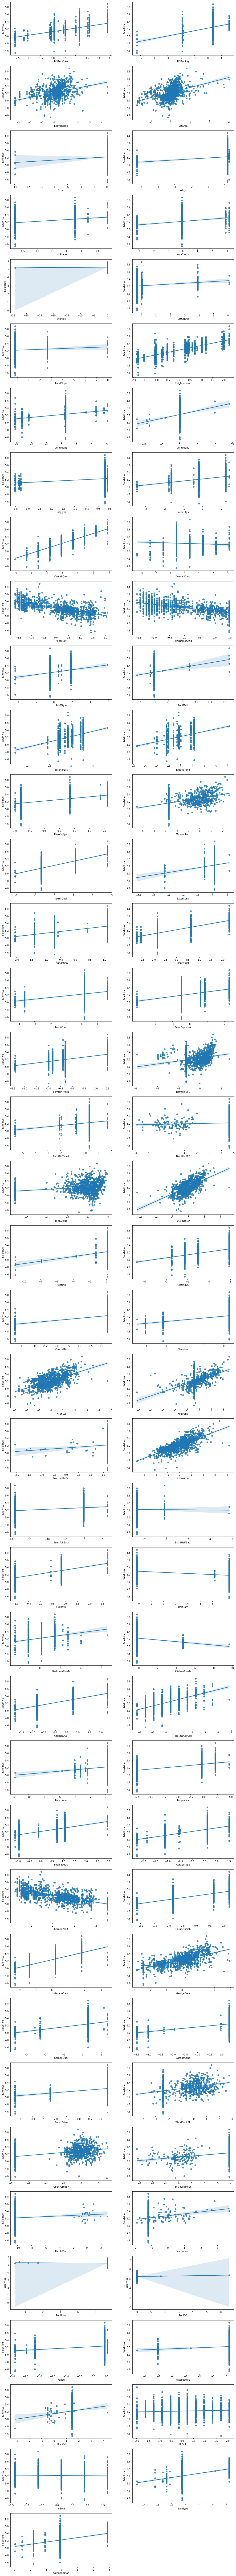

In [9]:
draw_trend(df_st_train)

### Select determinative numerical features

In [10]:
def sort_features(df):
    
    lst_m=[]
    
    # loop over numerical features
    for i in range(len(df.columns)-1):
        
        x = df.columns[i]

        results = smf.ols('SalePrice'+'~'+x, data=df).fit()
         
        b, m = results.params
        b_err, m_err = results.bse
        rsq = results.rsquared.item()
                
        lst_m.append([x,m,m_err,rsq])

        
    lst_m.sort(key = lambda x: x[3], reverse=True)    
    
    return lst_m

In [11]:
lst_m = sort_features(df_st_train)

In [12]:
sorted_features = [x[0] for x in lst_m]
print(sorted_features)

['OverallQual', 'Neighborhood', 'GrLivArea', 'GarageCars', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageArea', 'YearBuilt', 'GarageYrBlt', 'FullBath', 'GarageFinish', 'TotalBsmtSF', 'FlrSF1st', 'GarageType', 'MSSubClass', 'YearRemodAdd', 'FireplaceQu', 'Foundation', 'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC', 'BsmtFinType1', 'OpenPorchSF', 'FlrSF2nd', 'MasVnrType', 'MasVnrArea', 'MSZoning', 'Exterior1st', 'Exterior2nd', 'LotArea', 'GarageCond', 'BsmtExposure', 'GarageQual', 'WoodDeckSF', 'SaleCondition', 'LotFrontage', 'CentralAir', 'SaleType', 'HouseStyle', 'HalfBath', 'PavedDrive', 'LotShape', 'Electrical', 'BsmtCond', 'EnclosedPorch', 'BsmtFinSF1', 'BsmtFullBath', 'Fence', 'Condition1', 'BedroomAbvGr', 'BsmtUnfSF', 'BsmtFinType2', 'RoofStyle', 'ExterCond', 'Heating', 'LandContour', 'BldgType', 'Alley', 'RoofMatl', 'KitchenAbvGr', 'LotConfig', 'ScreenPorch', 'Condition2', 'Functional', 'MiscVal', 'MiscFeature', 'LowQualFinSF', 'Porch3Ssn', 'OverallCond', 'MoSold', 'LandSlope', 'Stre

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

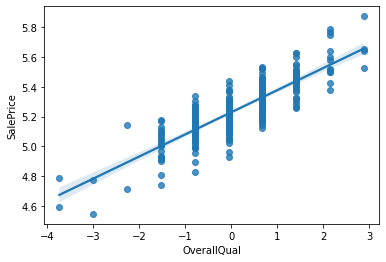

In [13]:
sns.regplot(x='OverallQual', y='SalePrice', data=df_st_test)


### Training and Test

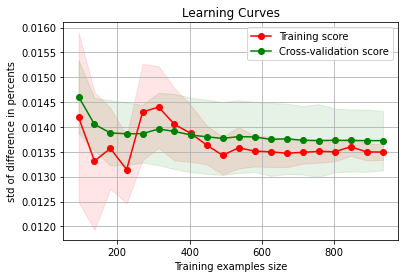

In [14]:
X_train = df_st_train[sorted_features[:10]]
y_train = df_st_train.SalePrice

X_test = df_st_test[sorted_features[:10]]
y_test = df_st_test.SalePrice

def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    # Copied and modified scikit-learn document
    ax = plt.subplot()

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples size")
    ax.set_ylabel("std of difference in percents")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, scoring=scoring, cv=cv, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")

    return plt

def cost_function(y, y_pred):
    
    # flip sign for make_scorer function to give positive output
    return -1.0*(np.square(np.log(abs(np.divide(y_pred,y)))).sum()/len(y))**0.5

def learning_curve_wrapper(X,y):
    
    n_samples = X.shape[0]
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)


    model = LinearRegression()
    scorer = metrics.make_scorer(cost_function, greater_is_better=False)
    #scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

    title = "Learning Curves"

    plot_learning_curve(model, title, X, y, scoring=scorer, train_sizes=np.linspace(.1, 1.0, 20))
    


    plt.show()
    
    return model

    
model = learning_curve_wrapper(X_train, y_train)

292
259


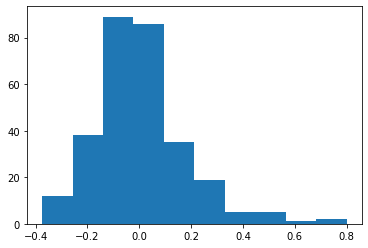

In [15]:
model.fit(X_train,y_train)

y_predict = model.predict(X_test)
y_diff = (10**y_predict-10**y_test)/10**y_test
plt.hist(y_diff)

print(len(y_diff))
print(len(y_diff[y_diff<0.2]))

In [17]:
print('Predict housing price within 20% for ',263/292*100,'% of data')

Predict housing price within 20% for  90.06849315068493 % of data
